## Debug the dissipation

In [1]:
%matplotlib inline

import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

### read saved data

In [2]:
file = '/g/data/nm03/lxy581/evaluate/dissip/M2_dissip_u_01_shelf_drag_const.nc'

In [3]:
data = xr.open_dataset(file)
dissip_u = data['dissip_u']

In [47]:
file_out   = '/g/data/nm03/lxy581/archive/tides_01_global_cdrag_const/output003/ocean_interior.nc'
fout  = xr.open_dataset(file_out)

# itime=np.arange(236)
uo = fout['uo'].isel(time=10)
tau = fout['taux_bot'].isel(time=10)
visc = fout['au_visc'].isel(time=10)

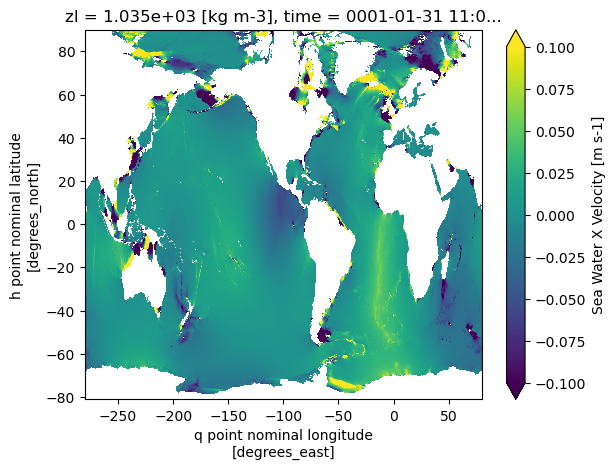

In [48]:
uo.plot(vmin=-0.1, vmax=0.1)

In [35]:
tau

<xarray.DataArray 'taux_bot' (yh: 2700, xq: 3601)> Size: 39MB
[9722700 values with dtype=float32]
Coordinates:
  * xq       (xq) float64 29kB -280.0 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yh       (yh) float64 22kB -81.11 -81.07 -81.02 -80.98 ... 89.89 89.94 89.98
    time     object 8B 0001-01-31 06:00:00
Attributes:
    units:          Pa
    long_name:      Zonal Bottom Stress from Ocean to Earth
    cell_methods:   yh:mean xq:point time: point
    interp_method:  none

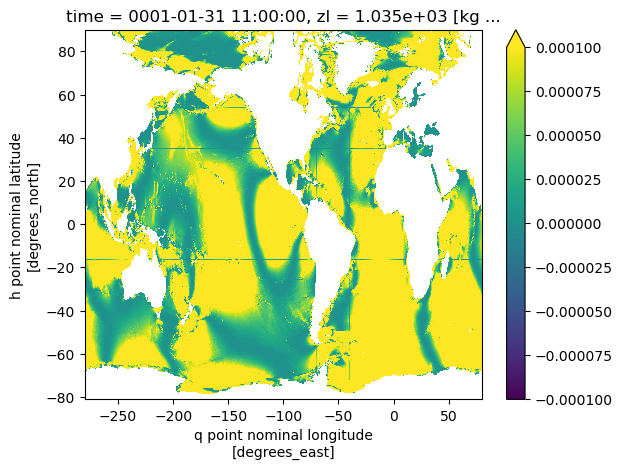

In [49]:
(tau*uo.isel(zl=0)).plot(vmin=-1e-4,vmax=1e-4)

In [37]:
tau_abs = ((tau**2)**0.5)

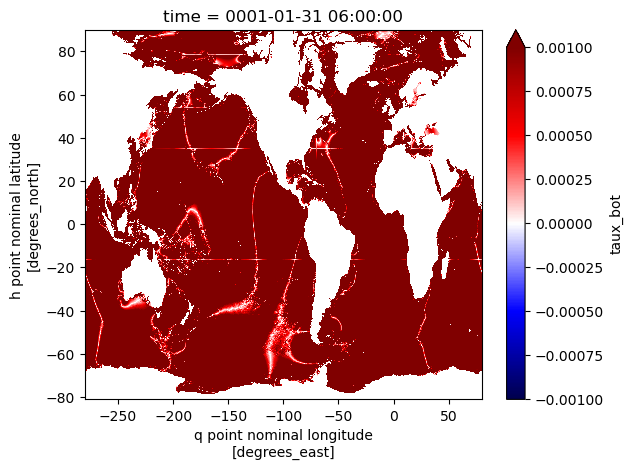

In [50]:
tau_abs.where(tau_abs>0.5e-4).plot.pcolormesh(vmin=-1e-3,vmax=1e-3,cmap='seismic')

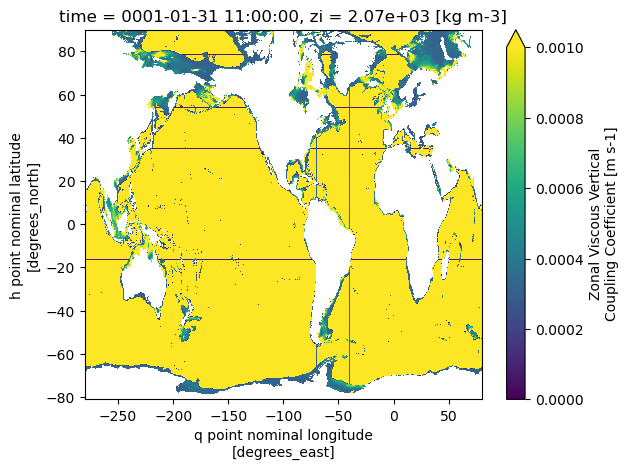

In [51]:
visc.isel(zi=1).plot(vmin=0,vmax=0.001)

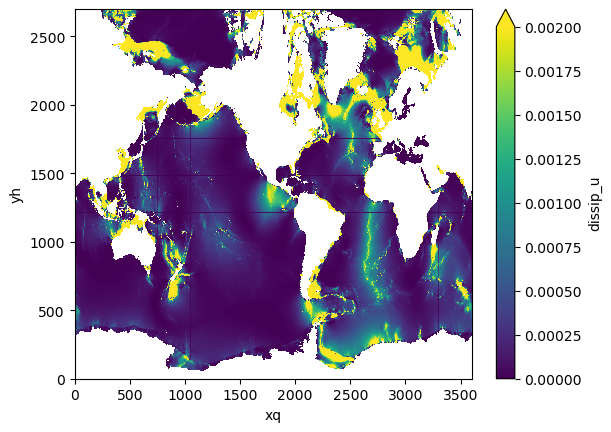

In [13]:
dissip_u.plot(vmin=0,vmax=0.002)

In [6]:
file_stats = '/g/data/nm03/lxy581/archive/tides_01_global_cdrag_const/output003/ocean_static.nc'
stats = xr.open_dataset(file_stats)
depth  = stats['deptho']
geolon = stats['geolon']
geolat = stats['geolat']
geolon_u = stats['geolon_u']
geolat_u = stats['geolat_u']
geolon_v = stats['geolon_v']
geolat_v = stats['geolat_v']
area   = stats['areacello']
yh, xh = stats.yh, stats.xh

In [8]:
topog = xr.open_dataset('/g/data/nm03/lxy581/input/tides_01deg_drag_coeff/ocean_topog.nc')
depth = topog.depth
depth_z = np.array(depth)
depth_z[depth_z==0]=np.nan
depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth_z),
                                }, 
                      coords={'lon': (('yh', 'xh'), np.array(geolon)),
                              'lat': (('yh', 'xh'), np.array(geolat))})
land = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

### Plot the snapshot of energy dissipation due to wave drag

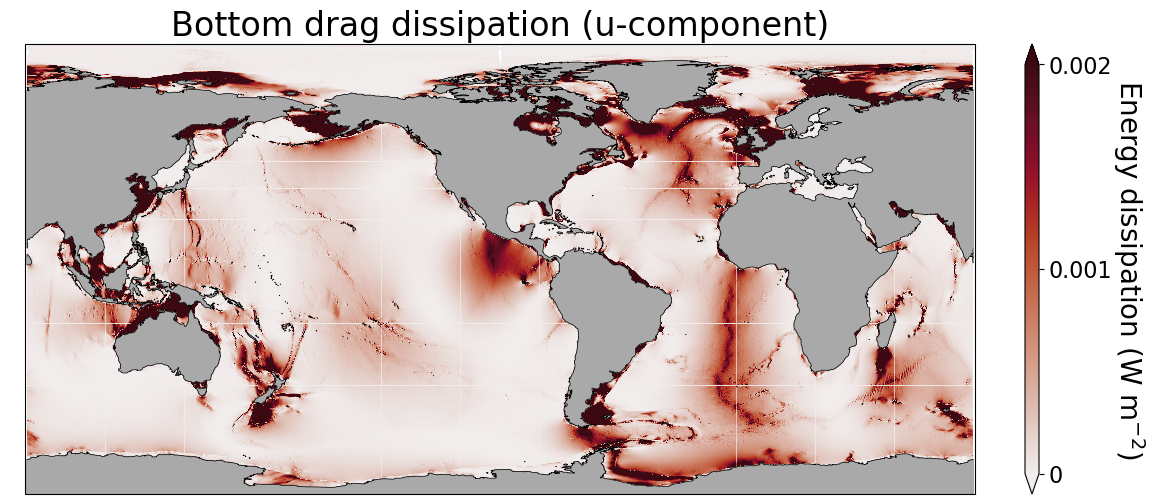

In [11]:
varlist = ['dissip_u']
title   = ['Bottom drag dissipation (u-component)']

tick_locs = np.array([0,0.001,0.002])
tick_labels = np.array(["0","0.001","0.002"])

fig = plt.figure(figsize=(14, 6))
axs = []

gridsubs = gridspec.GridSpec(1,1)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

for I, (ax, var) in enumerate(zip(axs, varlist)):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
    # Add model land mask
    land.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], add_colorbar=False, linewidths=0.5)

    p1 = ax.pcolormesh(geolon_u, geolat_u, globals()[var], cmap=cm.cm.amp, vmin=0, vmax=0.002)
    # p1 = ax.pcolormesh(geolon, geolat, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.deep, norm=LogNorm(vmin=1e-4, vmax=1e-2))
    plt.title(title[I],fontsize=24)
  
    ax.set_position([0.1,0.1,0.75,0.75])
    ax_cb = plt.axes([0.85, 0.1, 0.01, 0.75])
    
    cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel('Energy dissipation (W m$^{-2}$)',fontsize=20,rotation=270,labelpad=25);
    cb1.ax.tick_params(labelsize=16)
    cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
    cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
        
plt.savefig('/g/data/nm03/lxy581/exps_figs/M2_dissip_u_01_shelf_drag_const.png', dpi=300, bbox_inches='tight')